In [1]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
sys.path.insert(0, '/Users/sabhya/Documents/PyDeepGP')
import deepgp

In [2]:
np.random.seed(42)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("/Users/sabhya/Documents/PyDeepGP/weatherAUS.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217138,2022-08-26,Uluru,3.8,21.2,0.0,NaN,NaN,E,35.0,E,...,16.0,1024.2,1019.4,NaN,NaN,11.2,20.1,No,0.0,No
217139,2022-08-27,Uluru,3.2,24.6,0.0,NaN,NaN,ENE,28.0,ESE,...,10.0,1019.9,1014.3,NaN,NaN,12.2,23.4,No,0.0,No
217140,2022-08-28,Uluru,3.6,28.8,0.0,NaN,NaN,NW,48.0,ENE,...,8.0,1015.2,1011.4,NaN,NaN,15.1,28.1,No,0.0,No
217141,2022-08-29,Uluru,9.3,24.9,0.0,NaN,NaN,SE,31.0,S,...,24.0,1019.8,1017.9,NaN,NaN,15.5,23.8,No,0.0,No


In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [6]:
print("The number of No labels is: ", len(df[df.RainTomorrow.eq('No')]))
print("That constitutes: ", round(100*len(df[df.RainTomorrow.eq('No')])/len(df), 2), ' % of the dataset')

The number of No labels is:  164187
That constitutes:  75.61  % of the dataset


In [7]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,213597.0,12.013287,6.437902,-8.7,7.4,11.8,16.7,33.9
MaxTemp,213784.0,23.132537,7.139490,-4.1,17.9,22.5,28.1,48.9
Rainfall,210781.0,2.333787,8.547405,0.0,0.0,0.0,0.6,474.0
Evaporation,101279.0,5.489808,4.226591,0.0,2.6,4.8,7.4,138.7
Sunshine,92165.0,7.617073,3.771815,0.0,4.8,8.5,10.6,14.5
WindGustSpeed,200920.0,40.029041,13.577398,2.0,31.0,39.0,48.0,135.0
WindSpeed9am,212983.0,14.035618,8.886909,0.0,7.0,13.0,19.0,87.0
WindSpeed3pm,209412.0,18.581447,8.738994,0.0,13.0,17.0,24.0,87.0
Humidity9am,212294.0,68.979076,19.516599,0.0,57.0,70.0,84.0,100.0
Humidity3pm,208212.0,51.399818,21.083946,0.0,36.0,52.0,66.0,100.0


In [8]:
missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing

Sunshine         0.575556
Evaporation      0.533584
Cloud3pm         0.458131
Cloud9am         0.431375
Pressure9am      0.110637
Pressure3pm      0.110549
WindDir9am       0.078474
WindGustDir      0.075204
WindGustSpeed    0.074711
WindDir3pm       0.042543
Humidity3pm      0.041130
Temp3pm          0.035843
WindSpeed3pm     0.035603
RainToday        0.029299
Rainfall         0.029299
RISK_MM          0.029294
RainTomorrow     0.029294
Humidity9am      0.022331
WindSpeed9am     0.019158
Temp9am          0.016689
MinTemp          0.016330
MaxTemp          0.015469
Location         0.000000
Date             0.000000
dtype: float64

In [9]:
df = df.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'])

In [10]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

In [11]:
# fill categorical columns with mode
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].fillna(df[column].value_counts().idxmax())

In [12]:
# fill numerical columns with mean
for column in df.select_dtypes(include=['float64']).columns:
    df[column] = df[column].fillna(df[column].mean())

In [13]:
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

In [14]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

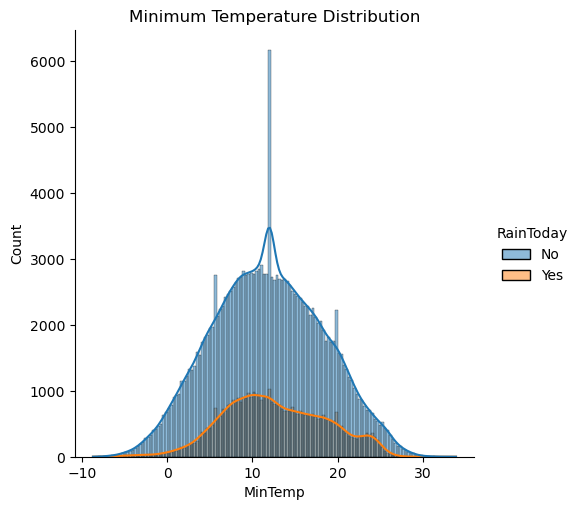

In [15]:
sns.displot(df, x='MinTemp', hue='RainToday', kde=True)
plt.title("Minimum Temperature Distribution")
plt.show()

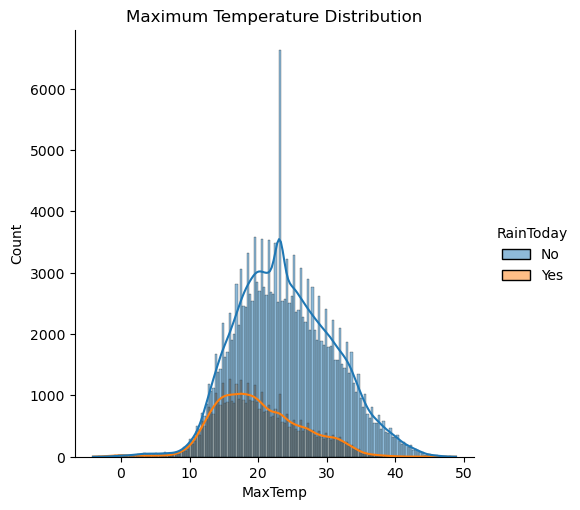

In [16]:
sns.displot(df, x='MaxTemp', hue='RainToday', kde=True)
plt.title("Maximum Temperature Distribution")
plt.show()

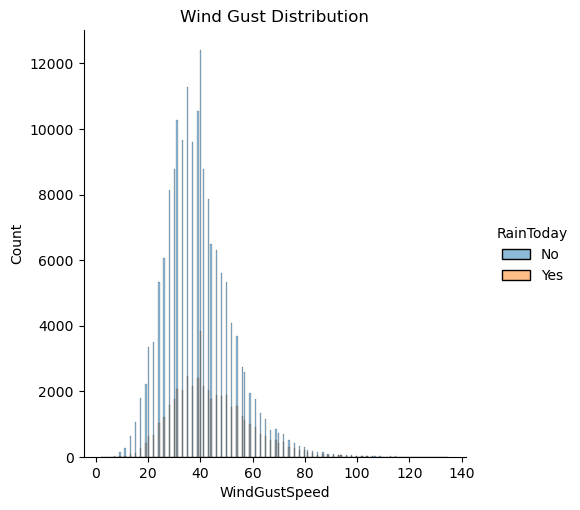

In [17]:
sns.displot(df, x='WindGustSpeed', hue='RainToday', )
plt.title("Wind Gust Distribution")
plt.show()

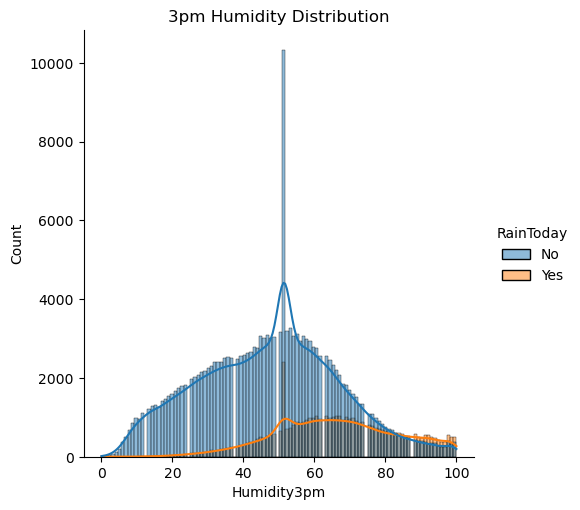

In [18]:
sns.displot(df, x='Humidity3pm', hue='RainToday', kde=True)
plt.title("3pm Humidity Distribution")
plt.show()

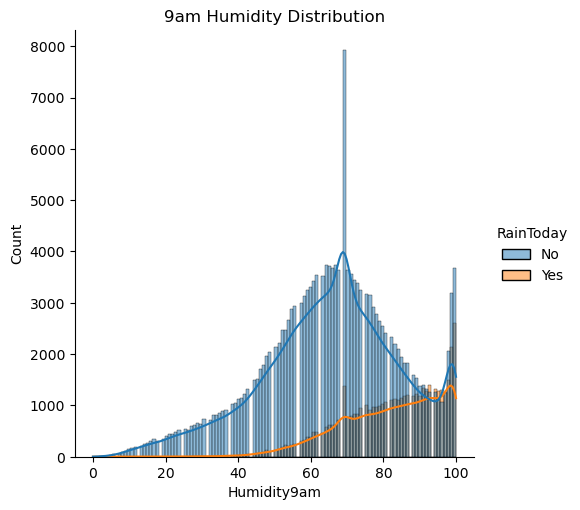

In [19]:
sns.displot(df, x='Humidity9am', hue='RainToday', kde=True)
plt.title("9am Humidity Distribution")
plt.show()

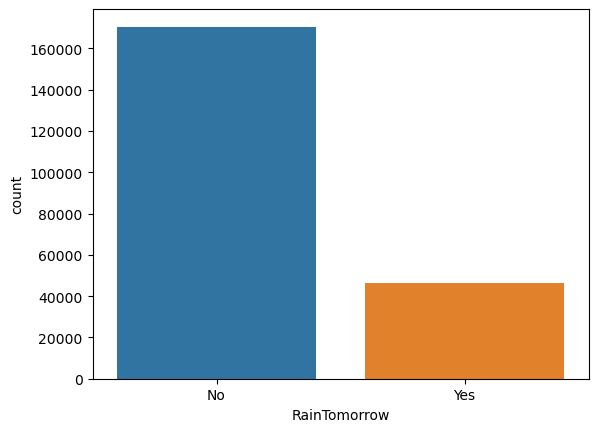

In [20]:
sns.countplot(x=df['RainTomorrow'])
plt.show()

In [21]:
df.index = df.Date
df = df.drop(columns=['Date'])
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,0.0,No
2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,0.0,No
2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,0.0,No
2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,1.0,No
2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26,Uluru,3.8,21.2,0.0,E,35.0,E,E,17.0,15.0,35.0,16.0,1024.2,1019.4,11.2,20.1,No,0.0,No
2022-08-27,Uluru,3.2,24.6,0.0,ENE,28.0,ESE,N,13.0,15.0,31.0,10.0,1019.9,1014.3,12.2,23.4,No,0.0,No
2022-08-28,Uluru,3.6,28.8,0.0,NW,48.0,ENE,WNW,7.0,20.0,24.0,8.0,1015.2,1011.4,15.1,28.1,No,0.0,No


In [22]:
objects = df.drop(columns=['Location']).select_dtypes(include = "object").columns
for i in range(len(objects)):
    df[objects[i]] = LabelEncoder().fit_transform(df[objects[i]])

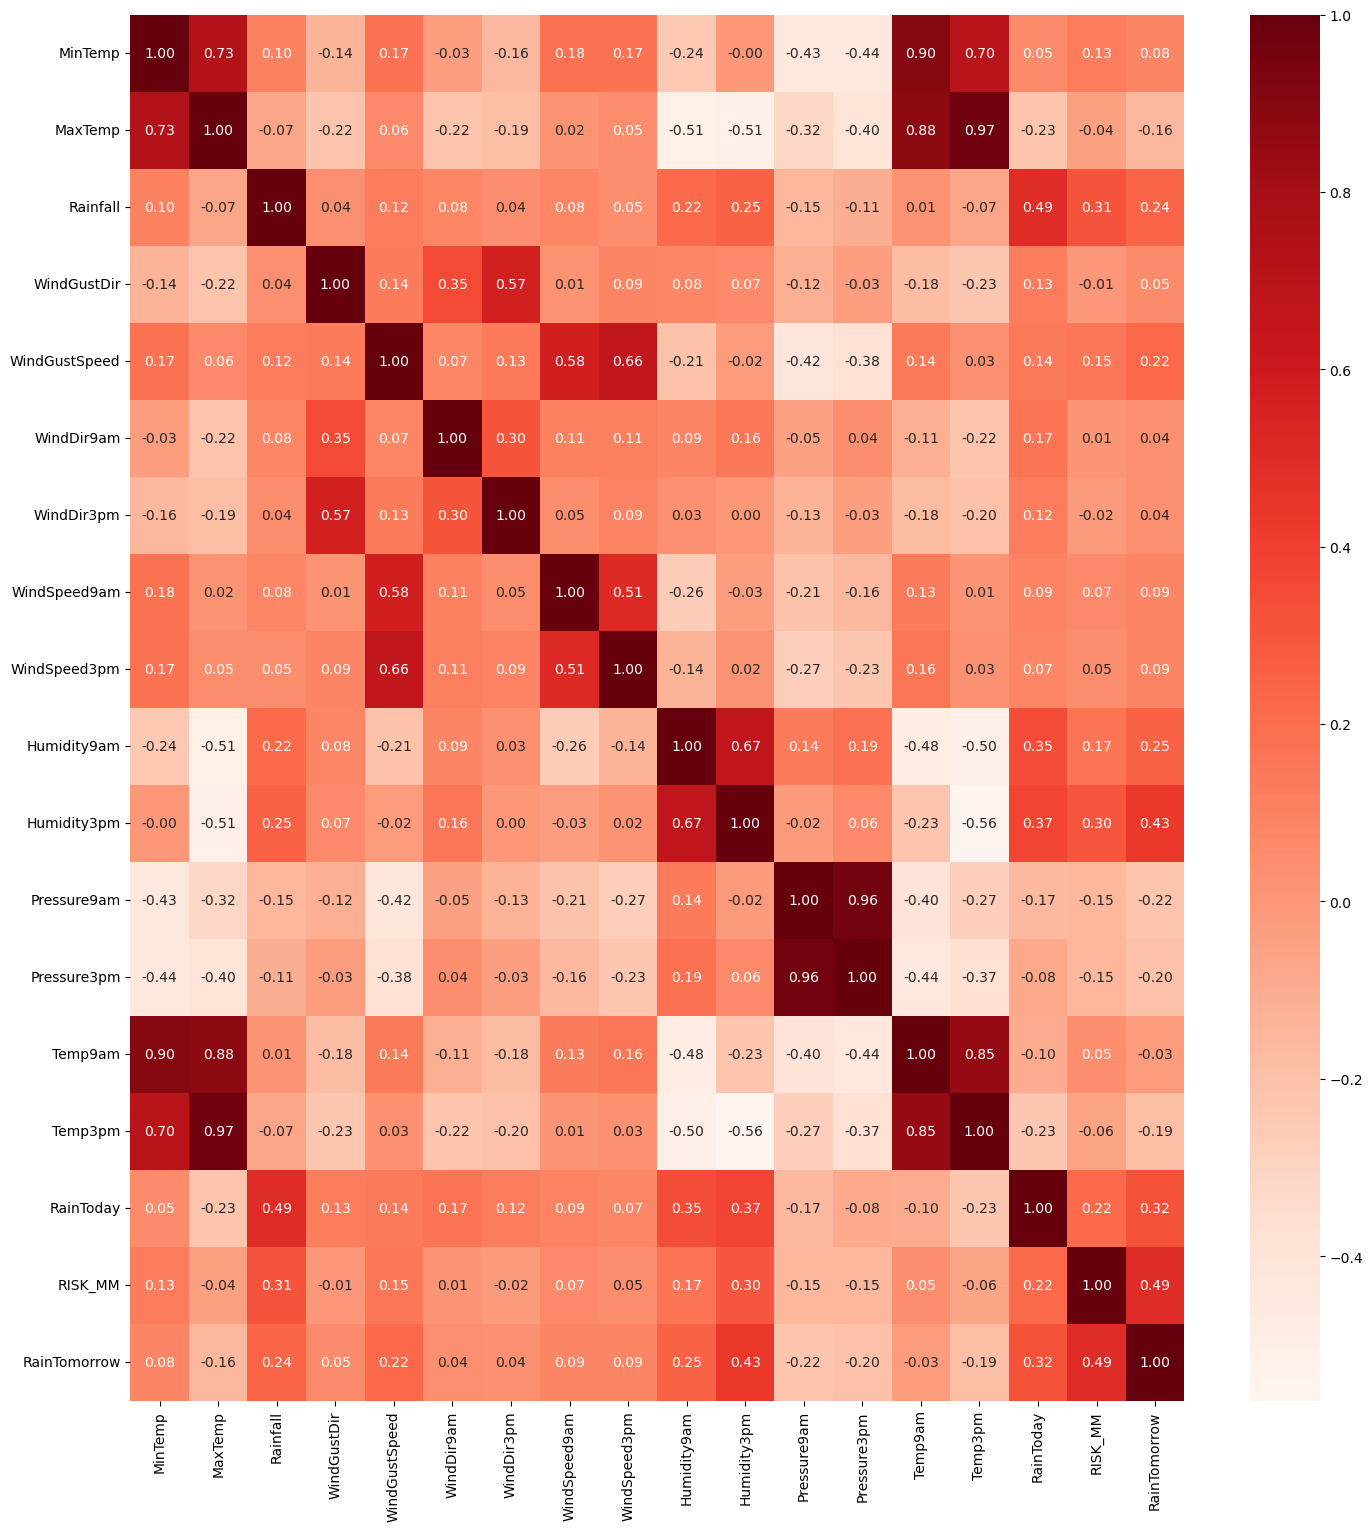

In [23]:
plt.figure(figsize=(17,18))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')
plt.show()

In [24]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir        int64
WindGustSpeed    float64
WindDir9am         int64
WindDir3pm         int64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday          int64
RISK_MM          float64
RainTomorrow       int64
dtype: object

In [25]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [26]:
def create_train_set(df):
    X = df.drop(columns=['RainTomorrow', 'Location'])
    y = df['RainTomorrow']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)
    return X_train, X_test, y_train, y_test 

In [27]:

X_train_al, X_test_al, y_train_al, y_test_al = create_train_set(df[df['Location']=="Albury"])
X_train_al.head(20)


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM
Date,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.600000,13,44.000000,13,14,20.000000,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0.00000
2008-12-02,7.4,25.1,0.000000,14,44.000000,6,15,4.000000,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0.00000
2008-12-03,12.9,25.7,0.000000,15,46.000000,13,15,19.000000,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0.00000
2008-12-04,9.2,28.0,0.000000,4,24.000000,9,0,11.000000,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,1.00000
2008-12-05,17.5,32.3,1.000000,13,41.000000,1,7,7.000000,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0.20000
2008-12-06,14.6,29.7,0.200000,14,56.000000,13,13,19.000000,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,0,0.00000
2008-12-07,14.3,25.0,0.000000,13,50.000000,12,13,20.000000,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,0,0.00000
2008-12-08,7.7,26.7,0.000000,13,35.000000,10,13,6.000000,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,0,0.00000
2008-12-09,9.7,31.9,0.000000,6,80.000000,9,7,7.000000,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,0,1.40000


In [28]:
X_train_al.shape
y_train_al.shape

(4079,)

In [34]:

y_train_al.values.reshape((4079, 1))

y_train_al.head()

Date
2008-12-01    0
2008-12-02    0
2008-12-03    0
2008-12-04    0
2008-12-05    0
Name: RainTomorrow, dtype: int64

In [29]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 3

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(Q,ARD=False) + GPy.kern.Bias(X_train_al.shape[1])

# Number of inducing points to use
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [30]:
m = deepgp.DeepGP([y_train_al.shape,Q,X_train_al.shape[1]],
                  y_train_al, X_train_al=X_train_al, kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=back_constraint)

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

In [ ]:
display(m)

In [ ]:
m.optimize(max_iters=800, messages=True)

In [ ]:
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

In [ ]:
m.optimize(max_iters=1500, messages=True)

In [ ]:
m_GP = GPy.models.SparseGPRegression(X=X_train_al, Y=Y_train_al, kernel=GPy.kern.RBF(X_train_al.shape[1])+GPy.kern.Bias(X_train_al.shape[1]), num_inducing=num_inducing)

In [ ]:
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())

In [ ]:
Y_pred = m.predict(X_ts)[0]
Y_pred_s = m.predict_withSamples(X_ts, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_ts)[0]

print('# RMSE DGP               : ' + str(rmse(Y_pred, Y_ts)))
print('# RMSE DGP (with samples): ' + str(rmse(Y_pred_s, Y_ts)))
print('# RMSE GP                : ' + str(rmse(Y_pred_GP, Y_ts)))